In [1]:
import pandas as pd
import numpy as np

In [33]:
df_raw: pd.DataFrame = pd.read_csv(
    '../data/processed_data.csv',
    parse_dates=["Time"],
    index_col=[0],
    sep=';'
)

threshold = 1500
df = df_raw[df_raw['Corrente motor'] > threshold]

# Drop all rows with NaN values
df = df.dropna().copy()

In [34]:
def create_vibration_windows(df, feature_column='feature', window_size=30, threshold=1.5):
    end_indices = np.where(df[feature_column] > threshold)[0]

    windows = []
    used_indices = set()

    for idx in end_indices:
        start_idx = idx - (window_size - 1)  # calcular inicio da janela
        if start_idx < 0:
            continue  # skip janelas antes do inicio do DF

        # Verificar se existe sobreposicao
        if any(i in used_indices for i in range(start_idx, idx + 1)):
            continue

        # Adicionar janela
        windows.append(df.iloc[start_idx:idx + 1])

        # Marcar indices
        used_indices.update(range(start_idx, idx + 1))

    return windows

def create_non_vibration_windows(df, critical_windows, feature_column='feature', threshold=1.5):
    # Criar janelas não críticas (janelas aleatórias abaixo do threshold)
    non_critical_windows = []
    for _ in range(len(critical_windows)):  # Criar o mesmo número de janelas não críticas
        start_idx = np.random.randint(0, len(df) - 30)  # Escolher um índice aleatório
        window = df.iloc[start_idx:start_idx + 30]
        if window[feature_column].max() <= threshold:  # Garantir que a janela não é crítica
            non_critical_windows.append(window)

    return non_critical_windows

def remove_problematic_columns(df):
    # Lista para armazenar colunas a serem removidas
    columns_to_drop = []

    # Verifica cada coluna no DataFrame
    for col in df.columns:
        # Verifica se a coluna contém tipos de dados não numéricos
        if df[col].dtype == 'object':
            print(f"Coluna '{col}' removida: contém tipo de dados 'object'.")
            columns_to_drop.append(col)
            continue

        # Verifica se a coluna contém valores não numéricos
        if not np.isfinite(df[col]).all():
            print(f"Coluna '{col}' removida: contém valores não numéricos (NaN ou infinito).")
            columns_to_drop.append(col)

    # Remove as colunas problemáticas
    df_cleaned = df.drop(columns=columns_to_drop)

    return df_cleaned

In [36]:
df = remove_problematic_columns(df)

critical_windows = create_vibration_windows(df)
non_critical_windows = create_non_vibration_windows(df, critical_windows)

# Rotular as janelas
critical_labels = [1] * len(critical_windows)  # 1 para críticas
non_critical_labels = [0] * len(non_critical_windows)  # 0 para não críticas

# Remover a coluna "feature" nas janelas críticas e não críticas
critical_windows = [window.drop(columns=['feature']) for window in critical_windows]
non_critical_windows = [window.drop(columns=['feature']) for window in non_critical_windows]

# Combinar janelas e rótulos
windows = critical_windows + non_critical_windows
labels = critical_labels + non_critical_labels

# Converter janelas para numpy array
X = np.array([window.values for window in windows])  # Usar todas as colunas da janela
y = np.array(labels)

In [5]:
print(len(critical_windows))
print(len(non_critical_windows))

1499
1081


In [37]:
X.shape

(2572, 30, 68)

In [7]:
y.shape

(2580,)

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Input, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt

Epoch 1/50


/usr/local/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-07 16:05:57.481236: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5307 - loss: 883.5336 - val_accuracy: 0.4407 - val_loss: 40.9365
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5192 - loss: 154.0913 - val_accuracy: 0.4455 - val_loss: 30.4759
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5493 - loss: 74.8596 - val_accuracy: 0.4358 - val_loss: 9.8885
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5501 - loss: 23.7215 - val_accuracy: 0.4358 - val_loss: 23.3590
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4693 - loss: 21.1569 - val_accuracy: 0.4068 - val_loss: 0.9041
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4523 - loss: 1.4199 - val_accuracy: 0.5690 - val_loss: 0.7721
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5962 - loss: 0.9237 - val_accuracy: 0.5617 - val_loss: 1.6324
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5875 - loss: 0.8321 - val_accuracy: 0.4116 - val_loss: 

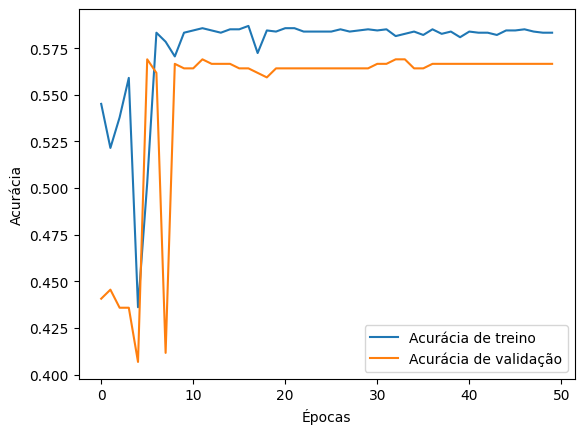

In [10]:
# Redimensionar X para o formato esperado pelo MLP (amostras, timesteps * n_features)
X_train_mlp = X_train.reshape(X_train.shape[0], -1)  # Achatar as dimensões de timesteps e features
X_test_mlp = X_test.reshape(X_test.shape[0], -1)

# Construir o modelo
model = Sequential([
    Dense(128, input_dim=X_train_mlp.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Saída binária (crítica ou não crítica)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train_mlp, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(X_test_mlp, y_test)
print(f"Acurácia: {accuracy:.2f}")

# Plotar o histórico de treino
plt.plot(history.history['accuracy'], label='Acurácia de treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5798 - loss: 0.6871 - val_accuracy: 0.6077 - val_loss: 0.6628
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6054 - loss: 0.6668 - val_accuracy: 0.5981 - val_loss: 0.6650
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6293 - loss: 0.6575 - val_accuracy: 0.6053 - val_loss: 0.6627
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6397 - loss: 0.6560 - val_accuracy: 0.6077 - val_loss: 0.6630
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6340 - loss: 0.6566 - val_accuracy: 0.6077 - val_loss: 0.6644
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6173 - loss: 0.6633 - val_accuracy: 0.6077 - val_loss: 0.6643
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6454 - loss: 0.6458 - val_accuracy: 0.6077 - val_loss: 0.6664
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6343 - loss: 0.6549 - val_accuracy: 0.6077 - val_loss:

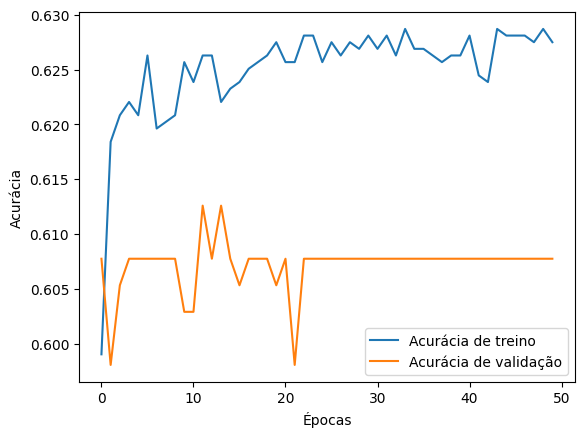

In [11]:
# Construir o modelo
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),  # (timesteps, n_features)
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Saída binária (crítica ou não crítica)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Acurácia: {accuracy:.2f}")

# Plotar o histórico de treino
plt.plot(history.history['accuracy'], label='Acurácia de treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

Epoch 1/50


/usr/local/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5215 - loss: 673.7719 - val_accuracy: 0.5375 - val_loss: 26.5673
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5526 - loss: 117.7567 - val_accuracy: 0.5327 - val_loss: 20.4251
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5841 - loss: 57.6394 - val_accuracy: 0.5085 - val_loss: 13.6284
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5227 - loss: 36.8881 - val_accuracy: 0.6029 - val_loss: 8.4954
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5473 - loss: 13.6369 - val_accuracy: 0.5956 - val_loss: 4.1227
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6060 - loss: 5.2755 - val_accuracy: 0.6005 - val_loss: 4.1285
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6029 - loss: 3.0723 - val_accuracy: 0.6102 - val_loss: 2.4537
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6013 - loss: 2.0121 - val_accuracy: 0.6077 - val_loss: 

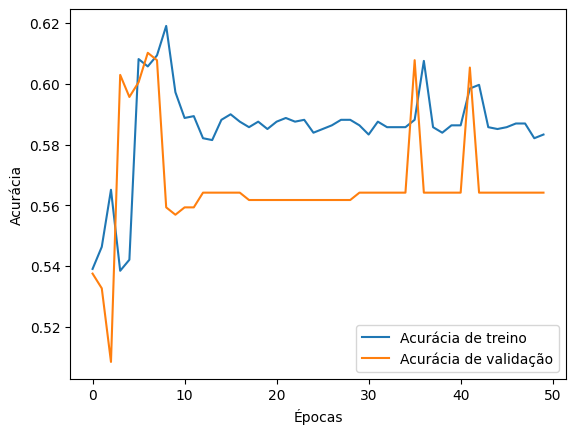

In [12]:
from tensorflow.keras.models import Sequential


# Construir o modelo
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Saída binária (crítica ou não crítica)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Acurácia: {accuracy:.2f}")

# Plotar o histórico de treino
plt.plot(history.history['accuracy'], label='Acurácia de treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

Epoch 1/50


/usr/local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5746 - loss: 0.7159 - val_accuracy: 0.6077 - val_loss: 0.6649
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6003 - loss: 0.6709 - val_accuracy: 0.6053 - val_loss: 0.6665
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5944 - loss: 0.6803 - val_accuracy: 0.5981 - val_loss: 0.6722
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6153 - loss: 0.6701 - val_accuracy: 0.5981 - val_loss: 0.6682
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5994 - loss: 0.6783 - val_accuracy: 0.6077 - val_loss: 0.6653
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6244 - loss: 0.6610 - val_accuracy: 0.6053 - val_loss: 0.6659
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6182 - loss: 0.6590 - val_accuracy: 0.6053 - val_loss: 0.6657
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6021 - loss: 0.6642 - val_accuracy: 0.6053 - val_loss: 0.6658
Epo

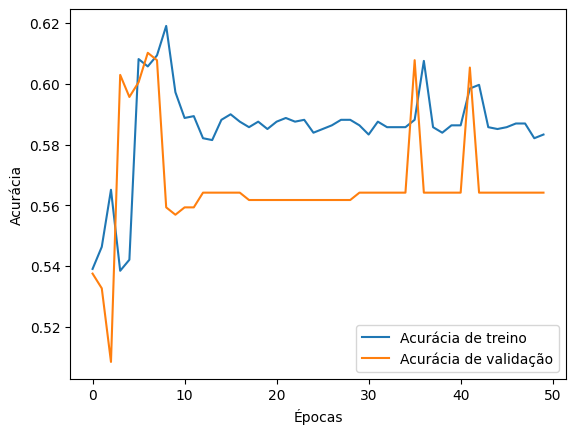

In [13]:
# Construir o modelo GRU
model_gru = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),  # (timesteps, n_features)
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Saída binária (crítica ou não crítica)
])

# Compilar o modelo
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history_gru = model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Avaliar o modelo
loss_gru, accuracy_gru = model_gru.evaluate(X_test, y_test)
print(f"Acurácia do GRU: {accuracy_gru:.2f}")

# Plotar o histórico de treino
plt.plot(history.history['accuracy'], label='Acurácia de treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [18]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [14]:
# Redimensionar X para o formato esperado pelo Random Forest
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)

# Treinar o modelo
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_rf, y_train)

# Avaliar o modelo
y_pred_rf = model_rf.predict(X_test_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia do Random Forest: {accuracy_rf:.2f}")

Acurácia do Random Forest: 0.95


In [22]:
# Redimensionar X para o formato esperado pelo XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

# Treinar o modelo
model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_train_xgb, y_train)

# Avaliar o modelo
y_pred_xgb = model_xgb.predict(X_test_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Acurácia do XGBoost: {accuracy_xgb:.2f}")

Acurácia do XGBoost: 1.00


In [40]:
X_reshaped = X.reshape(X.shape[0], -1)

# Criar o modelo XGBoost
model_xgb = XGBClassifier(random_state=42)

# Realizar validação cruzada com 5 folds
scores = cross_val_score(model_xgb, X_reshaped, y, cv=5, scoring='accuracy')

# Exibir os resultados
print(f"Acurácias em cada fold: {scores}")
print(f"Acurácia média: {np.mean(scores):.2f} ± {np.std(scores):.2f}")

Acurácias em cada fold: [0.4038835  0.87378641 0.71400778 0.35797665 0.41828794]
Acurácia média: 0.55 ± 0.20


In [20]:
X_reshaped.shape

(2580, 2070)